In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler


from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

from datetime import datetime

from statsmodels.tsa.arima.model import ARIMA

data = pd.read_csv("merged_data.csv")

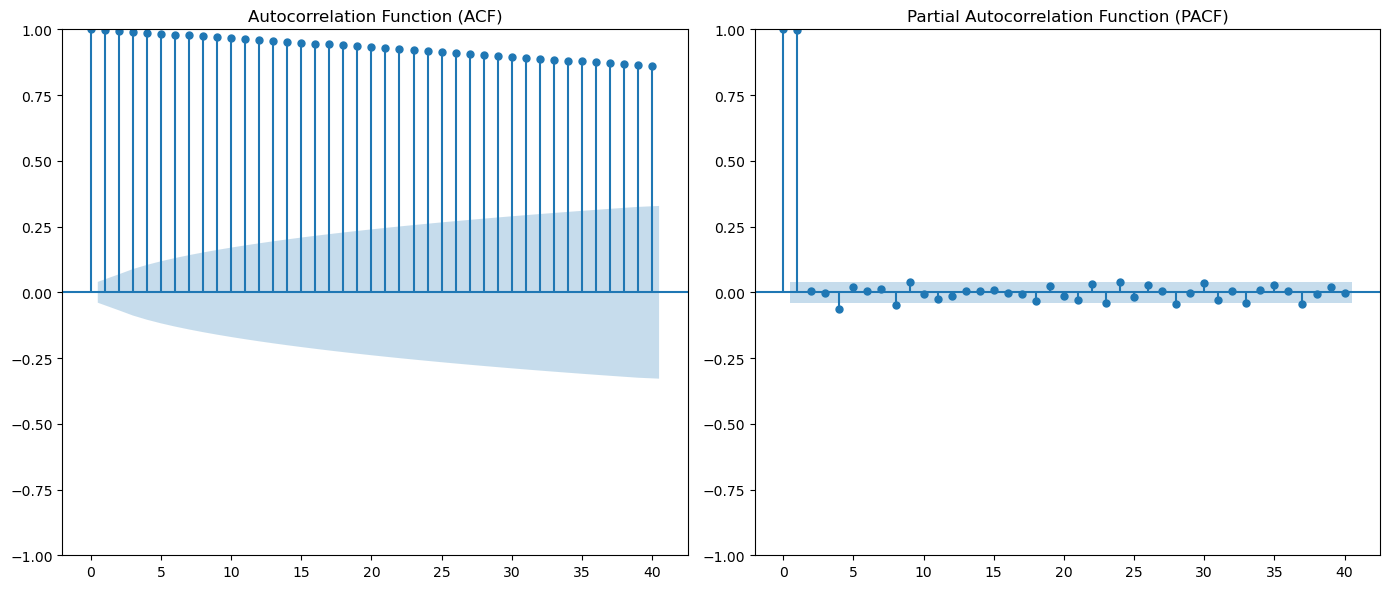

(-0.7868032282609213,
 0.8229678175875893,
 27,
 2421,
 {'1%': -3.433053943432798,
  '5%': -2.8627345707126906,
  '10%': -2.56740591915091},
 40373.061034174316)

In [5]:
# Check for stationarity using the Augmented Dickey-Fuller test
adf_result = adfuller(data['Close'])

# Plot ACF and PACF to determine ARIMA parameters
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plot_acf(data['Close'], lags=40, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

plt.subplot(1, 2, 2)
plot_pacf(data['Close'], lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

adf_result


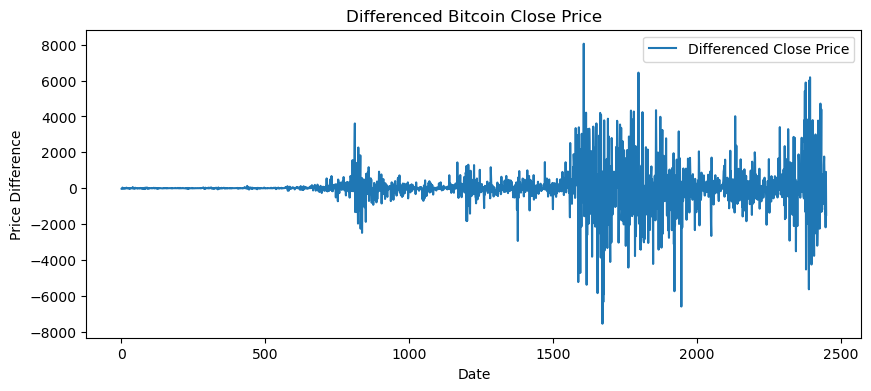

(-8.132890471458433,
 1.0783285944608516e-12,
 26,
 2421,
 {'1%': -3.433053943432798,
  '5%': -2.8627345707126906,
  '10%': -2.56740591915091},
 40356.03435579028)

In [7]:
# Apply first differencing to make the series stationary
data['Close_diff'] = data['Close'].diff()

# Drop NaN values that result from differencing
data.dropna(inplace=True)

# Recheck for stationarity using the ADF test
adf_result_diff = adfuller(data['Close_diff'])

# Plot the differenced data to visually inspect
plt.figure(figsize=(10, 4))
plt.plot(data.index, data['Close_diff'], label='Differenced Close Price')
plt.title('Differenced Bitcoin Close Price')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.legend()
plt.show()

# ADF test result after differencing
adf_result_diff

In [13]:
# Splitting the data into training and testing sets (80-20 split)
split_index = int(0.8 * len(data))
train, test = data['Close'][:split_index], data['Close'][split_index:]

model_predictions = []
n_test_obser = len(test)

for i in range(n_test_obser):
    model = ARIMA(train, order=(1, 1, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output.iloc[0]  # Correct way to get the forecasted value
    model_predictions.append(yhat)
    actual_test_value = test.iloc[i]  # Correct way to access test data by index
    train = pd.concat([train, pd.Series([actual_test_value])], ignore_index=True)  # Using pd.concat instead of append# Calculate error metrics

mse = mean_squared_error(test, model_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, model_predictions)
r_squared = r2_score(test, model_predictions)

print(f'RMSE: {rmse}')
print(f"Mean Absolute Error: {mae}")
print(f"R-squared (R²): {r_squared}")

RMSE: 1259.9517615096497
Mean Absolute Error: 790.080086849524
R-squared (R²): 0.9939209235094236


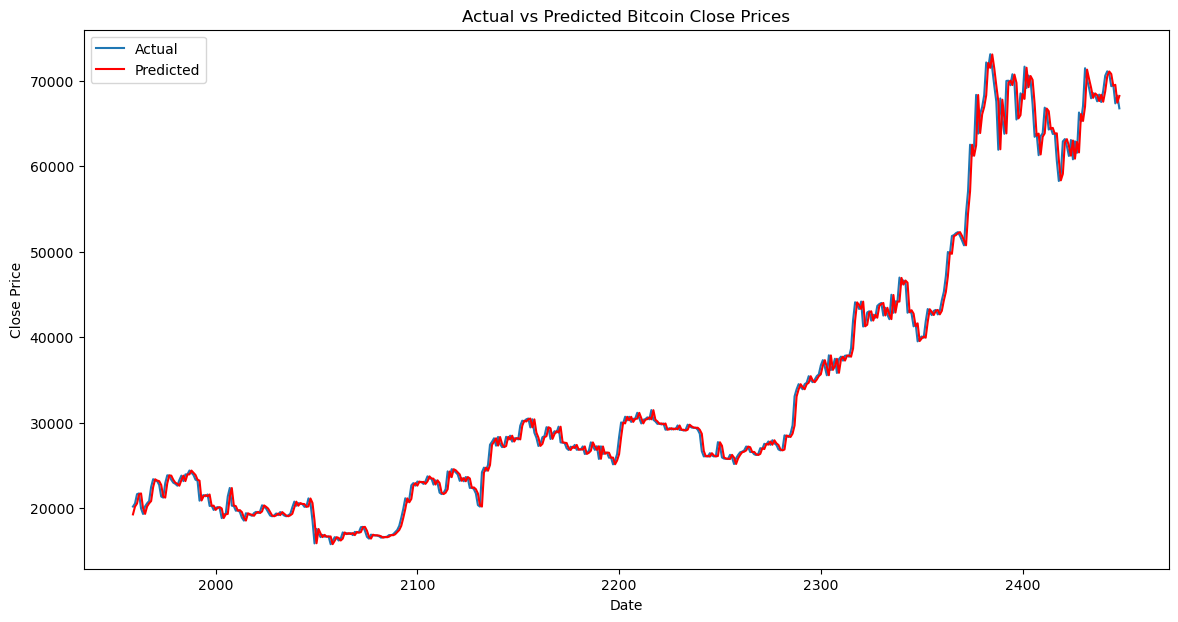

In [15]:
# Plot the results with the Date as the x-axis
plt.figure(figsize=(14, 7))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, model_predictions, color='red', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Bitcoin Close Prices')
plt.legend()
plt.show()

In [17]:
print (model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2448
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -20428.031
Date:                Tue, 27 Aug 2024   AIC                          40860.062
Time:                        03:52:59   BIC                          40871.668
Sample:                             0   HQIC                         40864.280
                               - 2448                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0400      0.011     -3.500      0.000      -0.062      -0.018
sigma2      1.044e+06   1.13e+04     92.625      0.000    1.02e+06    1.07e+06
Ljung-Box (L1) (Q):                   0.00   Jarque-